### Лаборатораная работа №3 (Леденцы)
#### Анализ и кластеризация данных методом DBSCAN

Ниже представлен стандартный код (как в предыдущих лабораторных):
* подключение библиотек,
* считывание файла,
* нормализация.

In [2]:
# Подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

plt.style.use('ggplot')

# Загружаем данные
df = pd.read_csv('data.dat', sep=';')
print(df.head())

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

   V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11
0   4   5   5   5   3   3   3   3   3    3    3
1   5   4   5   5   3   3   3   3   3    3    3
2   5   5   4   5   3   3   3   3   3    3    3
3   5   4   5   5   3   3   3   3   3    3    3
4   4   5   5   5   3   3   3   3   3    3    3


1. Кластеризация методом DBSCAN

Выберем радиус `eps = 1.5` и число соседей `min_samples = 5`.

In [4]:
dbscan1 = DBSCAN(eps=1.5, min_samples=5)
labels1 = dbscan1.fit_predict(X_scaled)

print("Уникальные метки:", np.unique(labels1))
print(pd.Series(labels1).value_counts())

Уникальные метки: [-1  0  1  2  3  4  5  6  7  8]
 0    101
 1     59
 8     52
 5     37
-1     33
 2     15
 6     15
 3     10
 7      9
 4      7
Name: count, dtype: int64


Использование выбранных параметров привело к образованию большого числа кластеров с нестандартным распределением точек, что затрудняет интерпретацию результатов.

Попробуем определить радиус с помощью графика k-distance

2. Визуальный метод для подбора eps: k-distance график

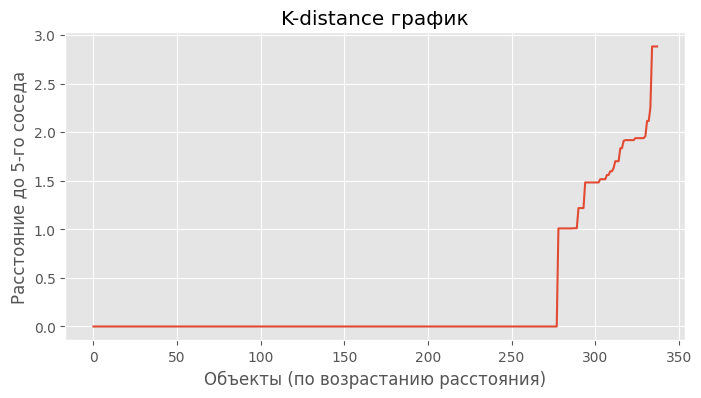

In [26]:
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances_sorted = np.sort(distances[:,-1])
plt.figure(figsize=(8,4))
plt.plot(distances_sorted)
plt.title(f"K-distance график")
plt.xlabel("Объекты (по возрастанию расстояния)")
plt.ylabel(f"Расстояние до {min_samples}-го соседа")
plt.grid(True)
plt.show()


Уже начиная с радиуса = 1 график резко растет вверх, а значит начиная с 1 появляются шумы, попробуем взять радиус = 2.0

Увеличим радиус до 2.0

In [32]:
dbscan2 = DBSCAN(eps=2.0, min_samples=5)
labels2 = dbscan2.fit_predict(X_scaled)

print("Уникальные метки:", np.unique(labels2))
print(pd.Series(labels2).value_counts())

Уникальные метки: [-1  0  1  2  3]
 0    110
 1    104
 2     61
 3     57
-1      6
Name: count, dtype: int64


3. Визуализация кластеров с помощью метода PCA для оценки их структуры

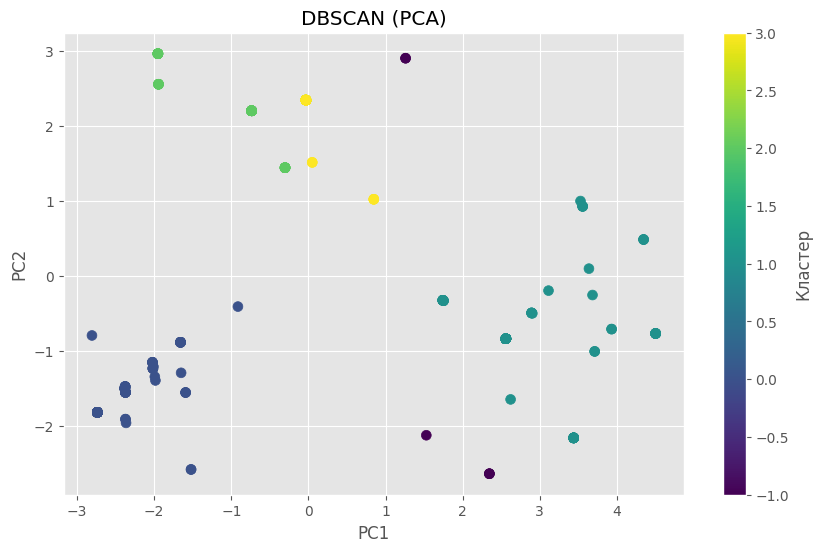

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels2, s=50)
plt.title("DBSCAN (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Кластер')
plt.show()


Кластеры 2 и 3, как и в методе K-Means, можно объединить в один кластер. Также видно, что кластер `-1` соответствует шумовым точкам.

Посмотрим, изменится ли распределение кластеров при увеличении или уменьшении значения `min_samples`.

Уникальные метки: [0 1 2 3 4 5]
Уникальные метки: [-1  0  1  2  3]


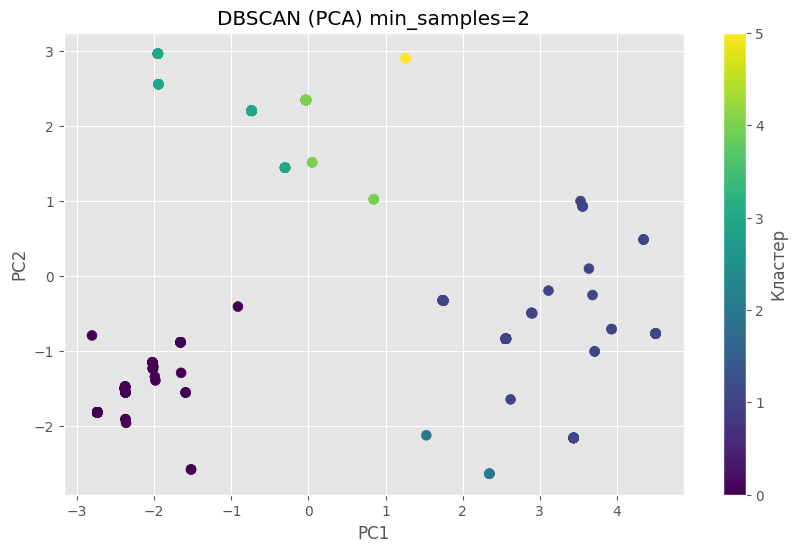

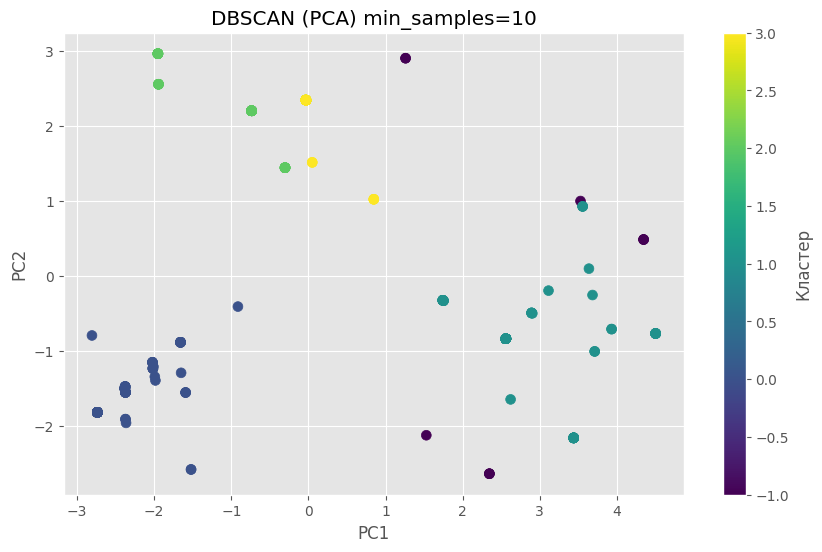

In [ ]:
dbscan3 = DBSCAN(eps=2.0, min_samples=2)
labels3 = dbscan3.fit_predict(X_scaled)

dbscan4 = DBSCAN(eps=2.0, min_samples=10)
labels4 = dbscan4.fit_predict(X_scaled)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels3, s=50)
plt.title("DBSCAN (PCA) min_samples=2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Кластер')
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels4, s=50)
plt.title("DBSCAN (PCA) min_samples=10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Кластер')
plt.show()

Анализируя графики, видно, что ни увеличение, ни уменьшение числа соседей существенно не улучшает распределение кластеров, хотя увеличение параметра работает немного лучше.

4. Средние значения признаков в кластерах

In [35]:
df['cluster'] = labels2
cluster_means = df.groupby('cluster').mean()
print("\nСредние значения признаков по кластерам:")
print(cluster_means)


Средние значения признаков по кластерам:
               V1        V2        V3        V4        V5        V6        V7  \
cluster                                                                         
-1       2.333333  3.333333  3.333333  3.333333  2.000000  2.333333  3.000000   
 0       4.845455  4.800000  4.836364  4.681818  3.036364  3.036364  3.000000   
 1       2.855769  2.788462  2.721154  2.567308  2.634615  2.605769  2.778846   
 2       3.000000  3.000000  3.000000  3.000000  4.852459  4.852459  3.000000   
 3       3.000000  3.000000  3.000000  2.947368  2.947368  2.947368  4.912281   

               V8        V9       V10       V11  
cluster                                          
-1       3.666667  4.333333  4.166667  4.166667  
 0       2.990909  3.072727  3.045455  3.045455  
 1       2.913462  4.951923  4.817308  4.865385  
 2       2.918033  2.754098  2.754098  2.754098  
 3       4.912281  3.000000  3.000000  3.000000  


5. Интерпретация кластеров

*Кластер -1*: Шумовые точки
- **Характеристика**: Непоследовательные или редкие оценки по большинству признаков (V1–V11)
- **Интерпретация**: Респонденты не вписываются в стабильные сегменты
- Рассматриваются как аномалии или исключения

*Кластер 0*: Функциональные потребители
- **Характеристика**: Высокие оценки по V1–V4 (освежение дыхания, уверенность, гигиена полости рта)
- **Интерпретация**: Сфокусированы на практической пользе продукта

*Кластер 1*: Оздоровительные потребители
- **Характеристика**: Очень высокие оценки по V9–V11 (облегчение боли в горле, улучшение самочувствия)
- **Интерпретация**: Ориентированы на здоровье и терапевтический эффект

*Кластер 2*: Эмоциональные потребители
- **Характеристика**: Очень высокие оценки по V5–V6 (удовольствие, заменитель сладостей)
- **Интерпретация**: Потребление ради эмоционального удовлетворения

*Кластер 3*: Расслабляющие/отвлекающие потребители
- **Характеристика**: Высокие оценки по V7–V8 (концентрация, отвлечение, расслабление)
- **Интерпретация**: Использование для психологического эффекта

### Вывод

Подбор параметров `eps` и `min_samples` для DBSCAN не всегда очевиден и требует дополнительных экспериментов, однако этот метод полезен для выявления выбросов и уникальных случаев.

В данной задаче наиболее наглядным и удобным оказался иерархический кластерный анализ, так как он позволяет получить 3 чётко интерпретируемых кластера.

K-Means выделяет 4 кластера, слегка дробя «средний» сегмент, но остаётся стабильным и интерпретируемым методом.

DBSCAN формирует 5 кластеров с дополнительными шумовыми точками, что удобно для обнаружения выбросов, но делает сегментацию более разветвлённой и сложной для интерпретации.
